In [131]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from nltk.stem import WordNetLemmatizer
import re
import string
from nltk.corpus import stopwords


In [3]:
# Load the dataset
df = pd.read_csv('Netflix_movies2025.csv',on_bad_lines='skip')

In [4]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [5]:
df.shape

(30863, 8)

In [6]:
#Data preprocessing
#Removing entries with unkown genres
netflix_df = df[df['Genre'].str.lower() != 'unknown']


genres=pd.value_counts(netflix_df.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  2223 different Genres in the dataset:
--------------------------------------------------
Genre
drama                                                  5167
comedy                                                 3541
romance                                                 896
action                                                  864
horror                                                  847
                                                       ... 
war-time romance melodrama                                1
gothic mystery/dance                                      1
drama co-produced by the national film board              1
feature animation                                         1
drama adapted from the play by michel-marc bouchard       1
Name: count, Length: 2223, dtype: int64


<ipython-input-6-94a56fcb6c1e>:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  genres=pd.value_counts(netflix_df.Genre)


In [71]:
#Get the top 6 most common genres
#top_genres = pd.DataFrame(genres[:6]).reset_index()
#top_genres.columns = ['genres', 'number_of_movies']
#top_genres
top_genres = netflix_df['Genre'].value_counts().nlargest(6).index.tolist()

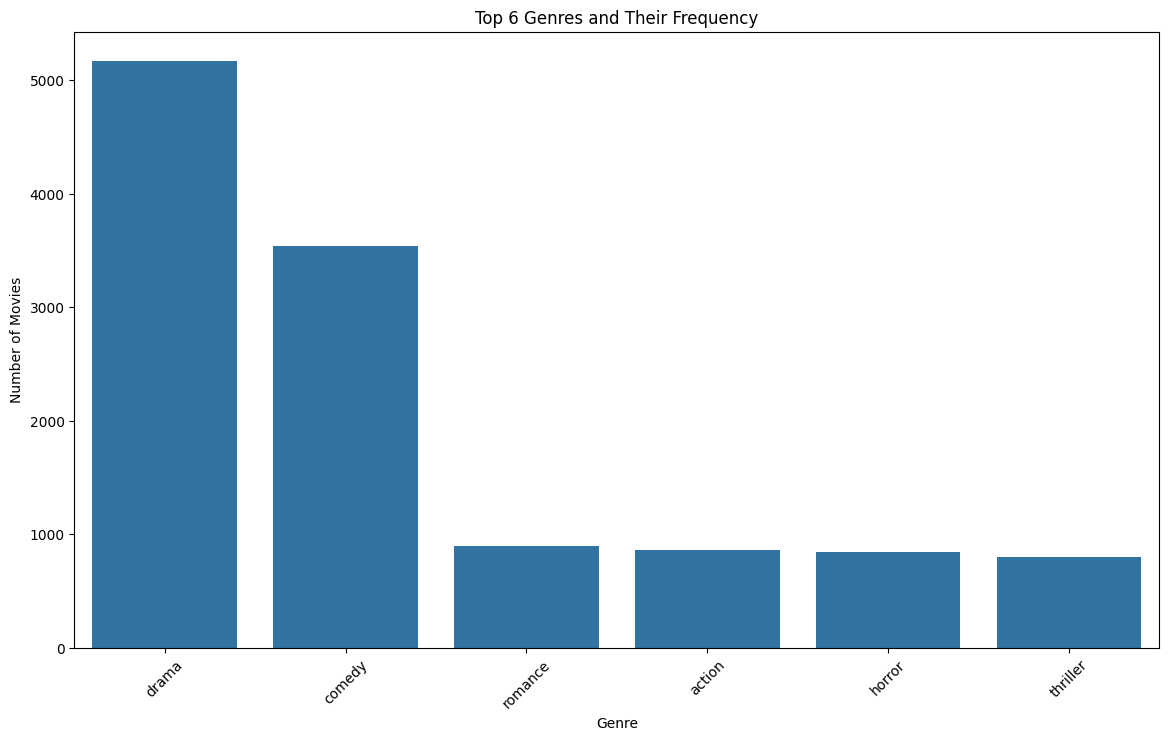

In [72]:
# Get the genre counts for the top 6 genres
top_genres = netflix_df['Genre'].value_counts().head(6)

# Plotting the genre distribution
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=top_genres.index, y=top_genres.values, ax=ax)
plt.title('Top 6 Genres and Their Frequency')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [73]:
#Create a new 'Labels' column for the top genres
def assign_genre_label(genre):
    if genre == 'drama':
        return 1
    elif genre == 'comedy':
        return 2
    elif genre == 'horror':
        return 3
    elif genre == 'action':
        return 4
    elif genre == 'thriller':
        return 5
    elif genre == 'romance':
        return 6
    else:
        return None


In [74]:
df['Labels'] = df['Genre'].apply( lambda x: assign_genre_label(x.lower()) if isinstance(x, str) and x.lower() in top_genres else None)

In [75]:
label_counts = df['Labels'].value_counts().sort_index()

# Display the count of items under each label
print(label_counts)

Labels
1.0    5167
2.0    3541
3.0     847
4.0     864
5.0     802
6.0     896
Name: count, dtype: int64


In [76]:
#Subsetting the netflix_df dataframe to only include the rows that have only a single genre entry
netflix_df = df[df['Labels'].notna()]

In [77]:
#Now we reduced the size of dataset to around 12000
netflix_df.shape

(12117, 9)

In [78]:
#removing unnecessary columns
netflix_df.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)

<ipython-input-78-a8f82ba8c954>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_df.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)


In [79]:
netflix_df.head()

,Title,Genre,Plot,Labels
7,The Suburbanite,comedy,The film is about a family who move to the sub...,2.0
14,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2.0
15,Laughing Gas,comedy,The plot is that of a black woman going to the...,2.0
16,The Adventures of Dollie,drama,On a beautiful summer day a father and mother ...,1.0
17,The Black Viper,drama,A thug accosts a girl as she leaves her workpl...,1.0


In [18]:
#Total number of words in the Plot summaries
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(netflix_df['Plot'])

In [19]:
#Total number of UNIQUE words in the plot summaries
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_unique_length = unique_word_length(netflix_df['Plot'])

In [24]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [104]:
# Define a function to clean and preprocess the plot descriptions

def clean_plot(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply the function to the 'Plot' column
netflix_df['Cleaned_Plot'] = netflix_df['Plot'].apply(clean_plot)

# Check cleaned data
netflix_df[['Title', 'Cleaned_Plot']].head()

<ipython-input-104-98c3ef3df974>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_df['Cleaned_Plot'] = netflix_df['Plot'].apply(clean_plot)


,Title,Cleaned_Plot
7,The Suburbanite,film family move suburbs hoping quiet life thi...
14,How Brown Saw the Baseball Game,heading baseball game nearby ballpark sports f...
15,Laughing Gas,plot black woman going dentist toothache given...
16,The Adventures of Dollie,beautiful summer day father mother take daught...
17,The Black Viper,thug accosts girl leaves workplace man rescues...


In [33]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the 'Cleaned_Plot' column into a TF-IDF matrix
X = tfidf_vectorizer.fit_transform(netflix_df['Cleaned_Plot'])

# Create the label vector 'y'
y = netflix_df['Labels']

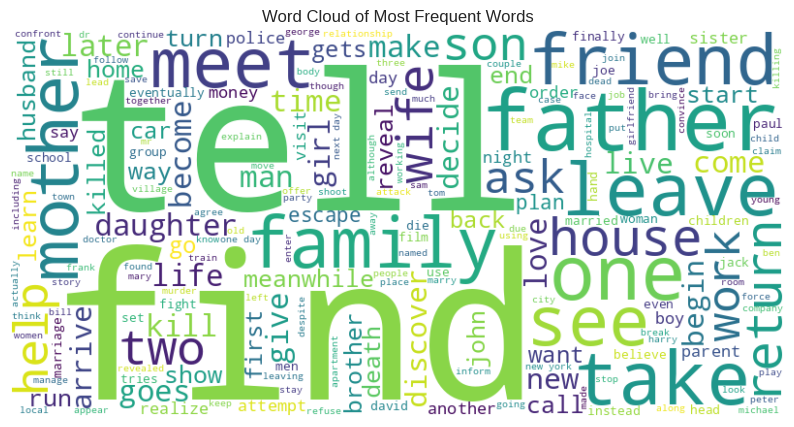

In [106]:
from wordcloud import WordCloud

# Combine all plot descriptions into one large text
all_plots = ' '.join(netflix_df['Cleaned_Plot'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_plots)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes for better visual
plt.title('Word Cloud of Most Frequent Words')
plt.show()

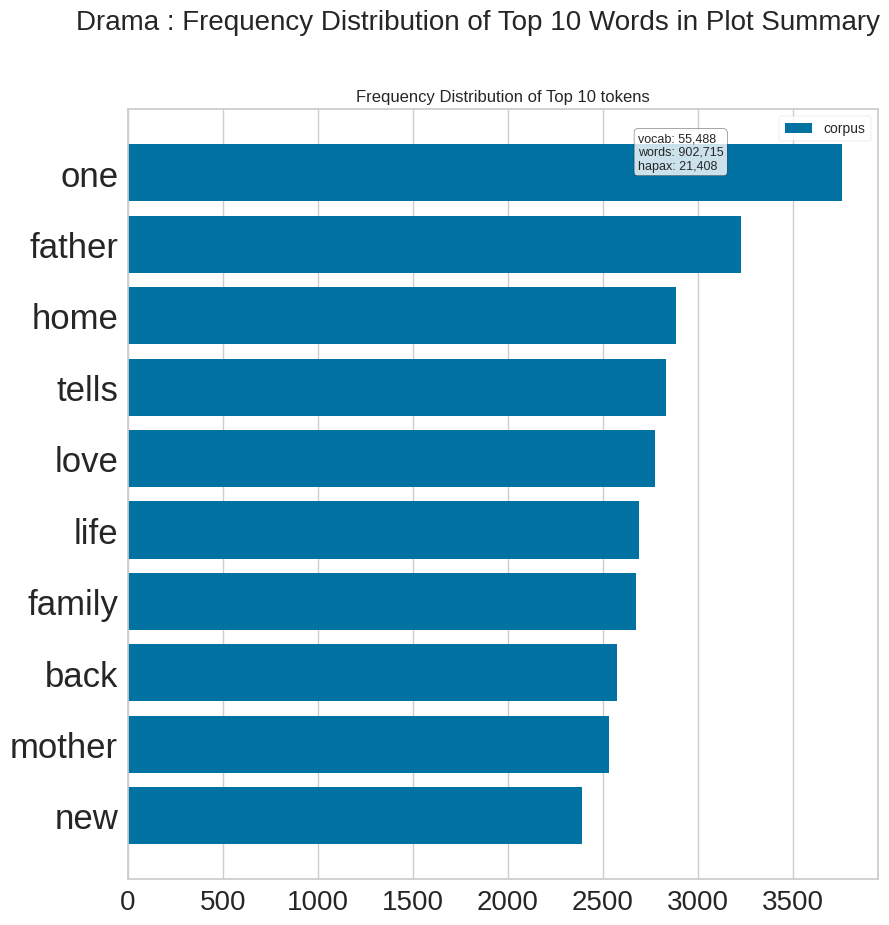

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [116]:
#For Drama most frequent words
drama_plot = netflix_df.loc[netflix_df['Labels'] == 1, ['Cleaned_Plot', 'Title']]
drama_plotlist = [x for x in drama_plot['Cleaned_Plot'].str.split()]
drama_plotlist = list(itertools.chain(*drama_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(drama_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Drama : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()

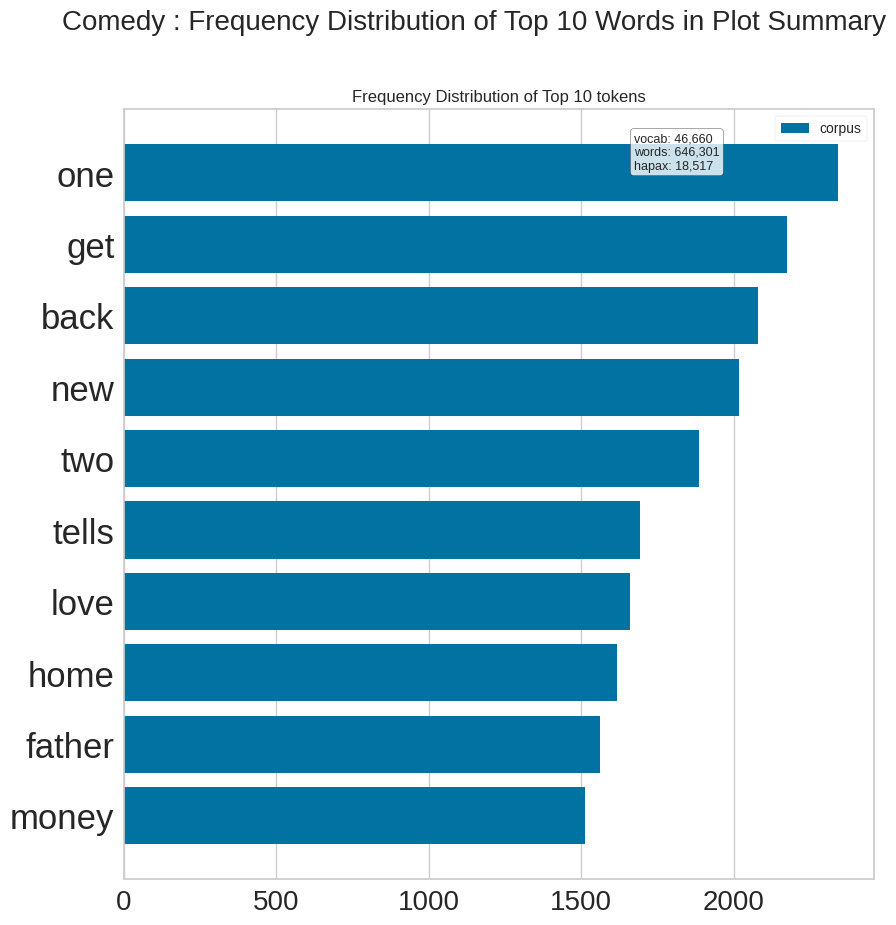

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [117]:
#For comedy most frequent words
comedy_plot = netflix_df.loc[netflix_df['Labels'] == 2, ['Cleaned_Plot', 'Title']]
comedy_plotlist = [x for x in comedy_plot['Cleaned_Plot'].str.split()]
comedy_plotlist = list(itertools.chain(*comedy_plotlist))


count = CountVectorizer()
docs       = count.fit_transform(comedy_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Comedy : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()

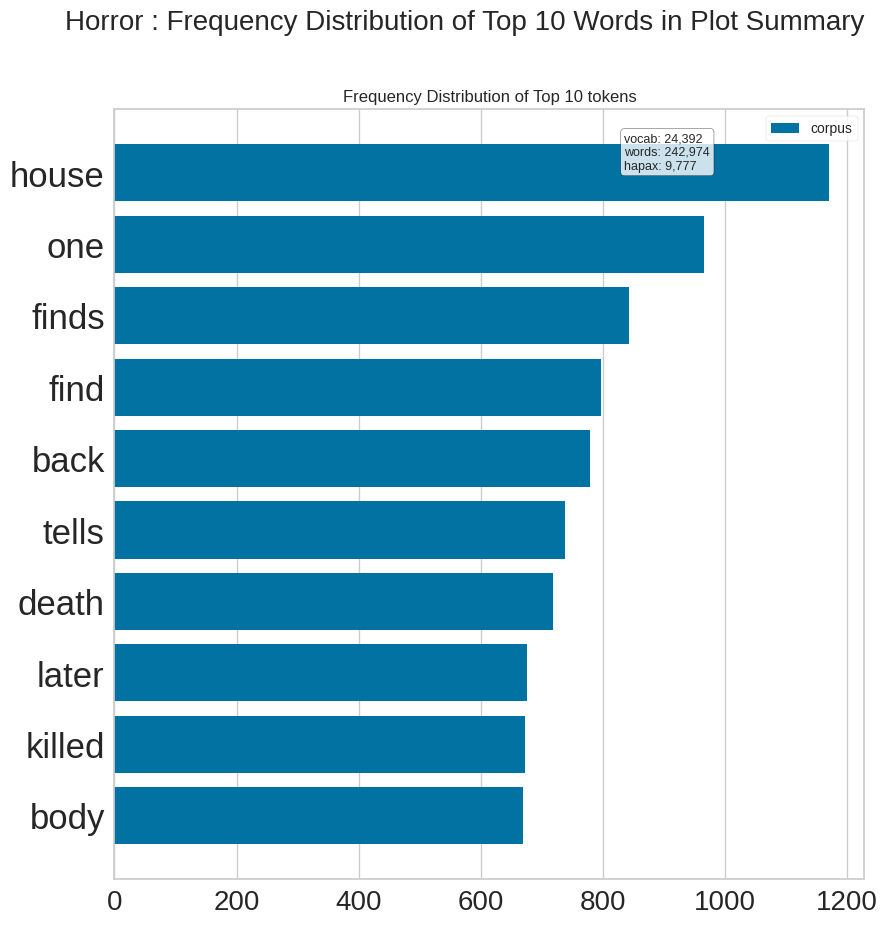

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [121]:
#For Horror most frequent words
horror_plot = netflix_df.loc[netflix_df['Labels'] == 3, ['Cleaned_Plot','Title']]
horror_plotlist = [x for x in horror_plot['Cleaned_Plot'].str.split()]
horror_plotlist = list(itertools.chain(*horror_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(horror_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Horror : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()

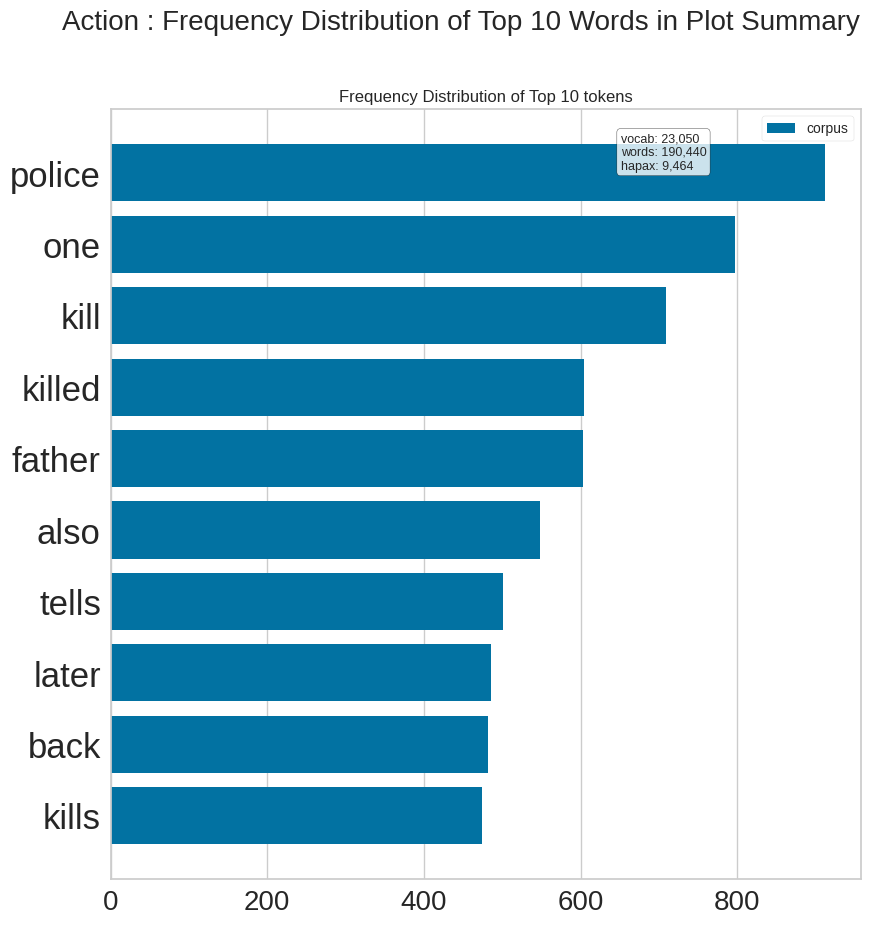

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [123]:
#For action most frequent words
action_plot = netflix_df.loc[netflix_df['Labels'] == 4, ['Cleaned_Plot', 'Title']]
action_plotlist = [x for x in action_plot['Cleaned_Plot'].str.split()]
action_plotlist = list(itertools.chain(*action_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(action_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Action : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()


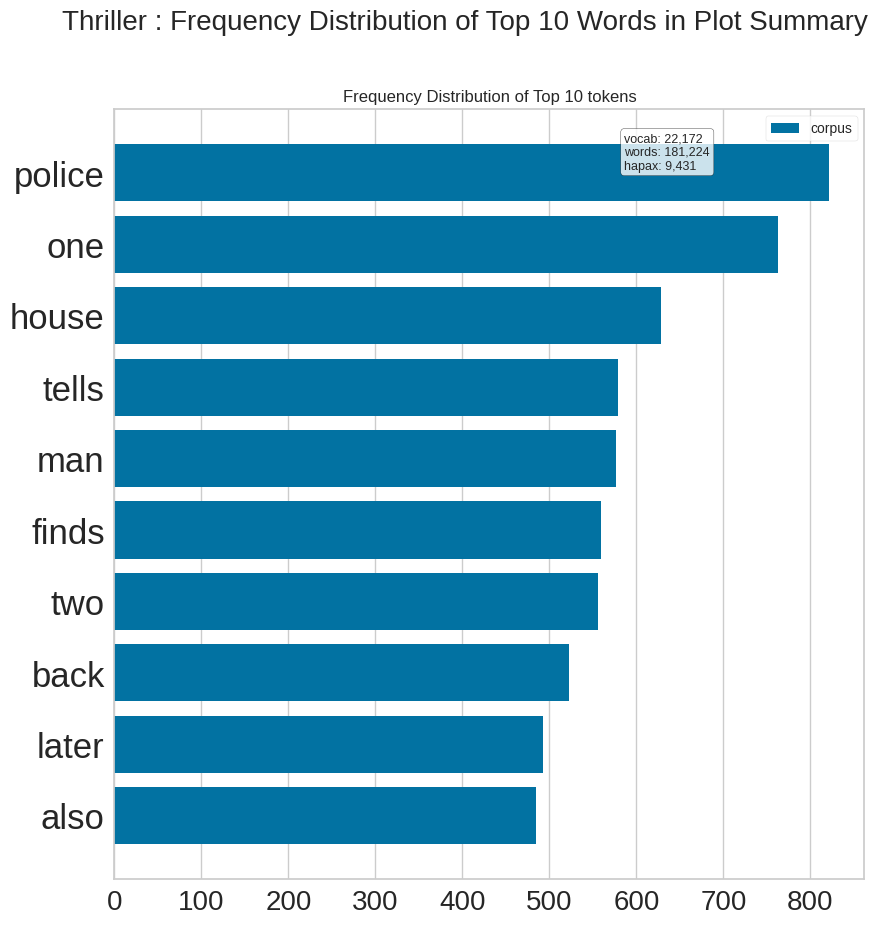

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [125]:
#For Thriller most frequent words
thriller_plot = netflix_df.loc[netflix_df['Labels'] == 5, ['Cleaned_Plot', 'Title']]
thriller_plotlist = [x for x in thriller_plot['Cleaned_Plot'].str.split()]
thriller_plotlist = list(itertools.chain(*thriller_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(thriller_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Thriller : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()

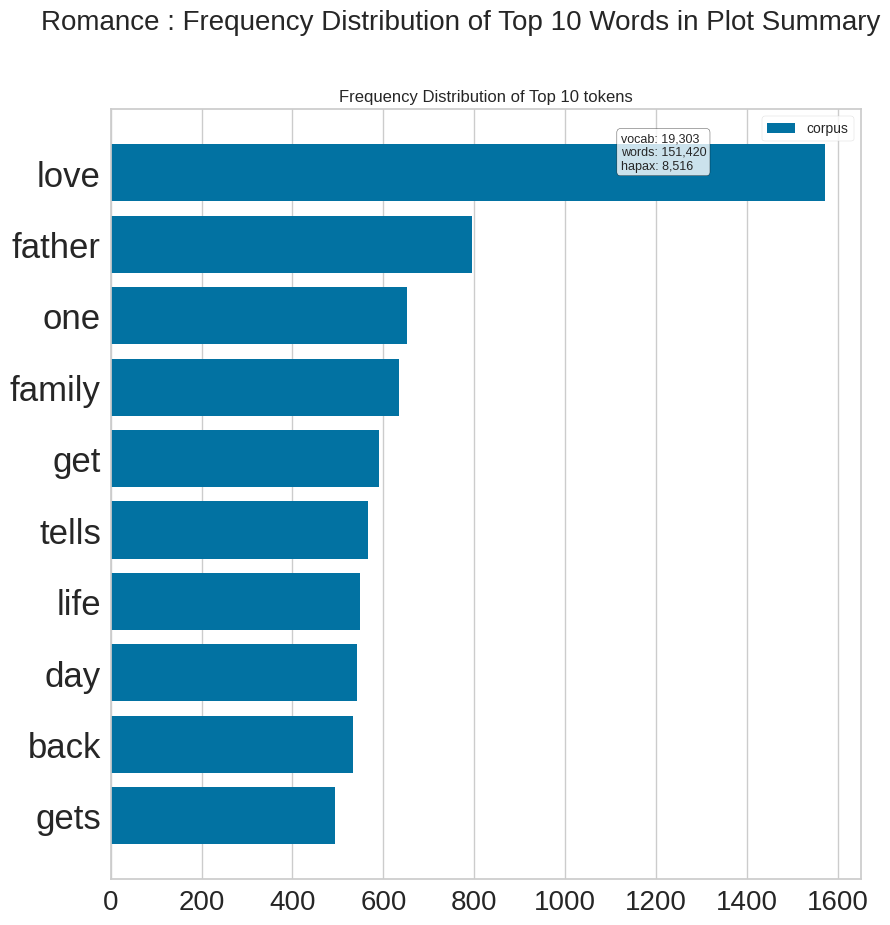

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [127]:
#For romance most frquent words
romance_plot = netflix_df.loc[netflix_df['Labels'] == 6, ['Cleaned_Plot', 'Title']]
romance_plotlist = [x for x in romance_plot['Cleaned_Plot'].str.split()]
romance_plotlist = list(itertools.chain(*romance_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(romance_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Romance : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()

In [91]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [39]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [41]:
# Neural Network (MLP)
nn_model = MLPClassifier(max_iter=1000)
nn_model.fit(X_train, y_train)

MLPClassifier(max_iter=1000)

In [136]:
# Make predictions
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
nn_pred = nn_model.predict(X_test)

# Print classification reports
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_pred))

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred))

print("Support Vector Machine Performance:")
print(classification_report(y_test, svm_pred))

print("Neural Network Performance:")
print(classification_report(y_test, nn_pred))

Logistic Regression Performance:
              precision    recall  f1-score   support

         1.0       0.60      0.78      0.68      1055
         2.0       0.62      0.61      0.62       713
         3.0       0.73      0.61      0.66       160
         4.0       0.56      0.38      0.45       168
         5.0       0.36      0.10      0.16       156
         6.0       0.48      0.18      0.26       172

    accuracy                           0.61      2424
   macro avg       0.56      0.44      0.47      2424
weighted avg       0.59      0.61      0.58      2424

Random Forest Performance:
              precision    recall  f1-score   support

         1.0       0.52      0.86      0.65      1055
         2.0       0.63      0.51      0.56       713
         3.0       0.65      0.36      0.46       160
         4.0       0.77      0.10      0.18       168
         5.0       0.50      0.01      0.01       156
         6.0       0.58      0.04      0.08       172

    accuracy     

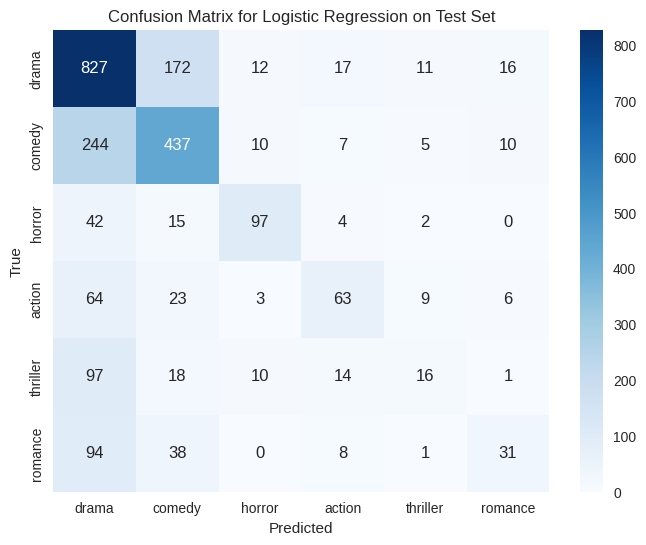

In [135]:
# confusion matrix for Logistic Regression on the test set
lr_pred = lr_model.predict(X_test)
y_pred = lr_model.predict(X_test)

conf_matrix_lr = confusion_matrix(y_test, lr_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=top_6_genres, yticklabels=top_6_genres)
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

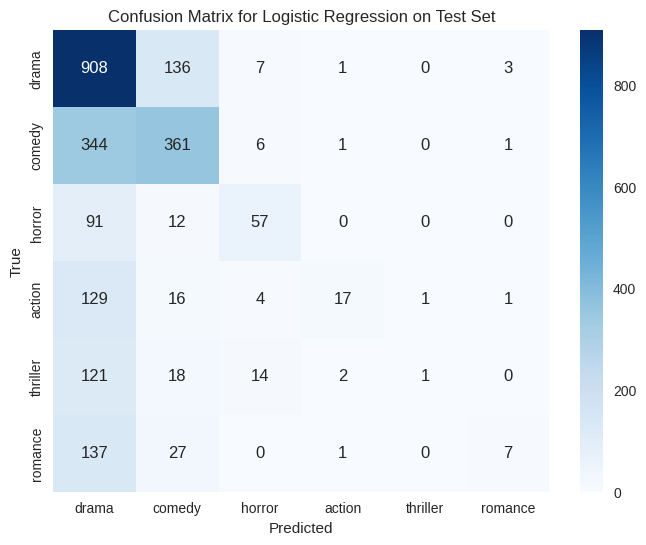

In [137]:
#confusion matrix for Random Forest on the test set
conf_matrix_lr = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=top_6_genres, yticklabels=top_6_genres)
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

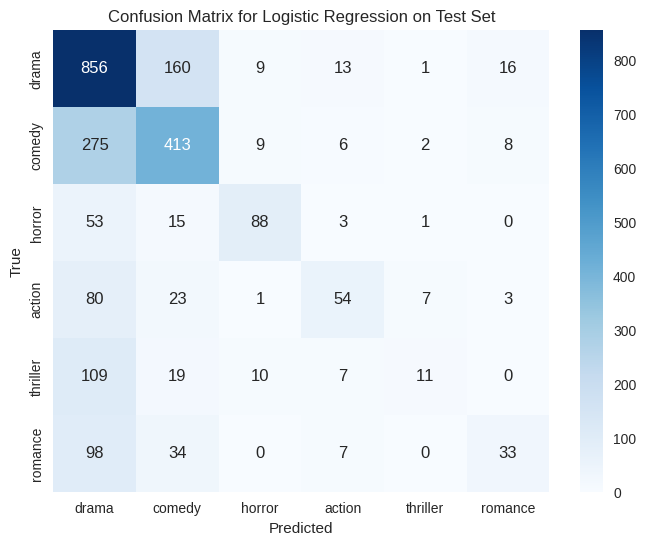

In [138]:
#confusion matrix for Support vector machine on the test set
conf_matrix_lr = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=top_6_genres, yticklabels=top_6_genres)
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

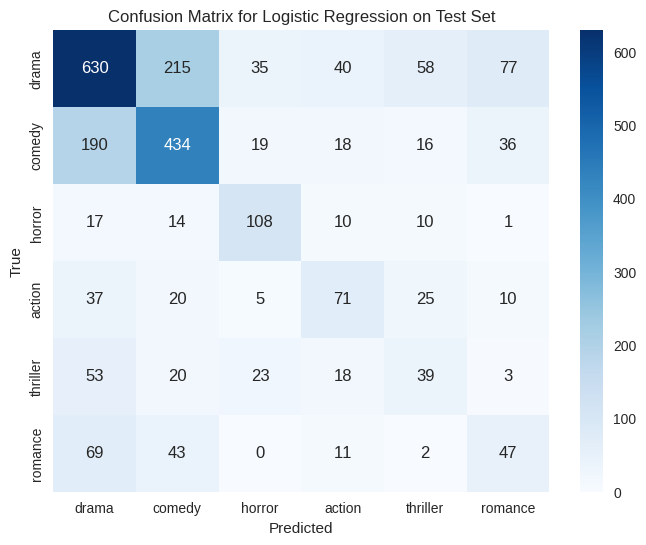

In [139]:
#confusion matrix for Neural network on the test set
conf_matrix_lr = confusion_matrix(y_test, nn_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=top_6_genres, yticklabels=top_6_genres)
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

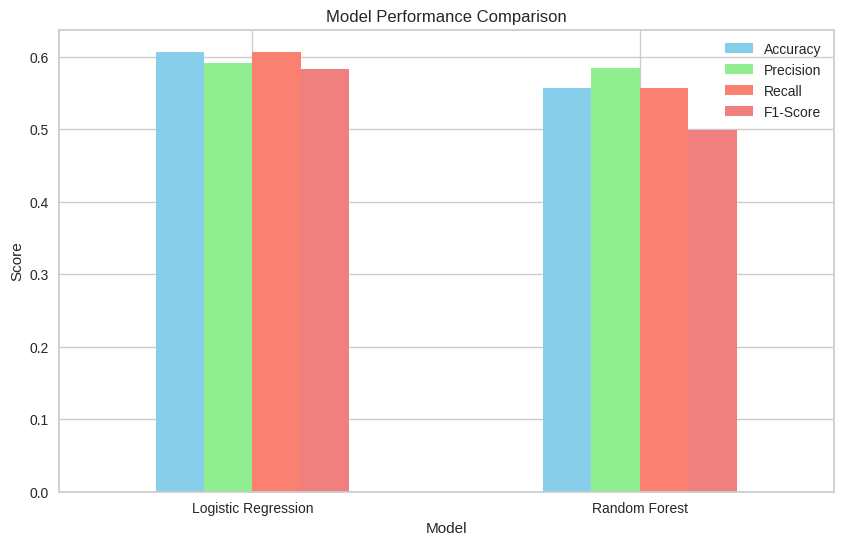

In [141]:
accuracy_rf = accuracy_score(y_test, rf_pred)
precision_rf = precision_score(y_test, rf_pred, average='weighted')
recall_rf = recall_score(y_test, rf_pred, average='weighted')
f1_rf = f1_score(y_test, rf_pred, average='weighted')

accuracy_lr = accuracy_score(y_test, lr_pred)
precision_lr = precision_score(y_test, lr_pred, average='weighted')
recall_lr = recall_score(y_test, lr_pred, average='weighted')
f1_lr = f1_score(y_test, lr_pred, average='weighted')


# Compare models
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_rf],
    'Precision': [precision_lr, precision_rf],
    'Recall': [recall_lr, recall_rf],
    'F1-Score': [f1_lr, f1_rf]
})

# Plot comparison
metrics.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()